<a href="https://colab.research.google.com/github/lcbjrrr/quant/blob/master/Reviews_Amazon_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoras: [Luciana Lima](https://www.linkedin.com/in/ACoAAAbxpjIBDyGzbb2940CTm2Oe5Wh6SBgNozg?lipi=urn%3Ali%3Apage%3Ad_flagship3_detail_base%3BMptFwXlkRZ2ho8Z2KTAFIw%3D%3D) e [Bárbara Silveira Fraga](https://www.linkedin.com/in/ACoAAA-kxkQBnlhvJPFli43yXL-RB7WNJ_u6JpA?lipi=urn%3Ali%3Apage%3Ad_flagship3_detail_base%3BMptFwXlkRZ2ho8Z2KTAFIw%3D%3D)

In [141]:
!pip install spacy
!pip install  https://github.com/explosion/spacy-models/releases/download/pt_core_news_sm-2.2.5/pt_core_news_sm-2.2.5.tar.gz
!python -m nltk.downloader stopwords

#!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2MB 1.6MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186282 sha256=815d831ce6e9f5bd7234637c30c1a26a268b28c5f35b0808397c4a1c42acd265
  Stored in directory: /root/.cache/pip/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [105]:
import pt_core_news_sm
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
from gensim.models import KeyedVectors
import warnings
from spacy import displacy 
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import spacy
import re
import string
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from nltk.cluster import KMeansClusterer, euclidean_distance
import nltk
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
tqdm_notebook.pandas()

In [74]:
df = pd.read_csv("https://raw.githubusercontent.com/barbarasilveiraf/reviews-amazon/master/data/amazon_reviews.csv", sep=";")

In [75]:
df.shape

(35, 2)

In [76]:
df.head()

,review,produto
0,Não posso comparar com as outras geração pois ...,kindle
1,"Aparelho excelente, porém o site está com falt...",kindle
2,Que bom que colocaram iluminação nesse novo Ki...,kindle
3,"Maravilhoso, anatômico e a luz realmente faz d...",kindle
4,"Amei esse kindle! Já tinha o outro, mais básic...",kindle


In [77]:
df["produto"].value_counts()

kindle              11
echodot             10
livro                9
petisco_cachorro     5
Name: produto, dtype: int64

In [78]:
df["tamanho_review"] = df["review"].apply(lambda x : len(x.split()))

In [79]:
df["tamanho_review"].describe()

count     35.000000
mean      46.542857
std       32.842174
min        9.000000
25%       21.000000
50%       37.000000
75%       57.500000
max      122.000000
Name: tamanho_review, dtype: float64

# Pos-tagging

Quero capturar itens específicos no meu texto, por isso vou aplicar o pos-tagging.

- Pos-tagging é a anotação de cada palavra em uma sentença, com um part-of-speech (marcador)
- Nível mais baixo da análise sintática: substantivo, verbo, pronome, preposição, adverbio, conjunção, artigos


https://spacy.io/api/annotation


In [106]:
#nlp = spacy.load("pt_core_news_sm")
 
nlp = pt_core_news_sm.load()

In [107]:
texto = df.loc[32, "review"]
texto

'Minhas cachorras amaram, entregou super rápido, só que vieram muitos quebrados.'

In [108]:
doc = nlp(texto)

In [109]:
displacy.render(doc, style='dep',jupyter=True)

In [110]:
df['substantivos'] = ""
df['substantivos'] = df['substantivos'].astype(object)

In [111]:
for i in df.index:
    pos_tags = {}
    doc = nlp(df.loc[i, "review"])
    for d in doc:
        if d.pos_ not in pos_tags.keys():
            #pos_tags[d.pos_] = [str(d.lemma_).lower()]
            pos_tags[d.pos_] = [str(d.text).lower()]
        else:
            pos_tags[d.pos_].append(str(d.text).lower())
    df.at[i, "substantivos"] = list(set(pos_tags["NOUN"]))

In [112]:
df.head()

,review,produto,tamanho_review,substantivos
0,Não posso comparar com as outras geração pois ...,kindle,57,"[pessoa, geração, medo, diferença]"
1,"Aparelho excelente, porém o site está com falt...",kindle,43,"[site, probleminha, falta, aparelho, capas]"
2,Que bom que colocaram iluminação nesse novo Ki...,kindle,44,"[hora, noite, suficiente, iluminação, geração,..."
3,"Maravilhoso, anatômico e a luz realmente faz d...",kindle,15,"[luz, vistas, diferença, perfeito, leitura]"
4,"Amei esse kindle! Já tinha o outro, mais básic...",kindle,25,"[variação, luz, causa, outro, diferença, ilumi..."


In [113]:
df["qtde_subs"] = df["substantivos"].apply(lambda x:len(x))

In [114]:
df["qtde_subs"].describe()

count    35.000000
mean      7.685714
std       5.160776
min       1.000000
25%       5.000000
50%       6.000000
75%       9.500000
max      20.000000
Name: qtde_subs, dtype: float64

# Uma forma de representar os substantivos

Precisamos de uma forma de representar os substantivos para que máquina entenda as relações entre eles. Para isso vamos utilizar embeddings (Word2Vec).

- Word2Vec é uma forma de representar o texto onde o contexto (palavras ao redor) é considerado.
- Vetores similares representam palavras similares, com semântica ou função semelhante.

Aqui vamos utilizar um embedding de 300 dimensões treinado com todos os dados da Wikipedia.


<i> Download embedding: https://wikipedia2vec.github.io/wikipedia2vec/pretrained/</i>

In [115]:
%%time
word_vectors = KeyedVectors.load_word2vec_format("http://wikipedia2vec.s3.amazonaws.com/models/pt/2018-04-20/ptwiki_20180420_100d.txt.bz2", binary=False,unicode_errors='ignore' )

CPU times: user 3min 14s, sys: 1.37 s, total: 3min 16s
Wall time: 3min 17s


## Conhecendo word2vec

### Vetor

In [116]:
word_vectors["cão"].shape

(100,)

In [117]:
word_vectors["cão"]

array([ 0.262 ,  0.6719, -0.0256, -0.3873,  0.4299, -0.2649,  0.0871,
        0.1203,  0.5013,  0.4609,  0.2657, -0.1331, -0.9416, -0.0776,
        0.1166,  0.2148,  0.1442, -0.179 ,  0.7406, -0.0501, -0.4807,
       -0.1335, -0.0873,  0.2716, -0.5493,  0.1204, -0.1098, -0.5517,
        0.062 , -0.2227, -0.234 ,  0.4237, -0.0542,  0.2493,  0.279 ,
        0.1763,  0.226 , -0.0086,  0.3267, -0.2871,  0.3558, -0.0587,
       -0.1527,  0.3941,  0.1835,  0.0427, -0.2077,  0.289 , -0.3192,
        0.2126,  0.1095, -0.3427,  0.1967,  0.5998, -0.0029, -0.216 ,
       -0.0793,  0.2127,  0.2572, -0.0545,  0.4226, -0.5403, -0.2944,
        0.1854,  0.0898,  0.5703, -0.0434, -0.0512, -0.0408,  0.158 ,
       -0.9705,  0.3193, -0.0871, -0.5753, -0.4876,  0.4818, -0.1188,
        0.3842, -0.2308,  0.0301,  0.5092, -0.4392, -0.249 , -0.3106,
       -0.0548,  0.2737, -0.2718, -0.4569,  0.0585,  0.4968,  1.2985,
       -0.1266, -0.0219, -0.2351,  0.0229,  0.6038,  0.14  , -0.0226,
       -0.0317,  0.8

### Similaridades

In [118]:
word_vectors.most_similar("cão")

[('cachorro', 0.8172596096992493),
 ('farejador', 0.7832717895507812),
 ('cães', 0.7741633653640747),
 ('uivador', 0.7717302441596985),
 ('antropomorfizado', 0.7624422311782837),
 ('poodle', 0.7596591711044312),
 ('dogue', 0.7519729137420654),
 ('rafeiro', 0.7490234971046448),
 ('dachshund', 0.7459341883659363),
 ('cãozinho', 0.744283139705658)]

In [119]:
word_vectors.most_similar("raiva")

[('medo', 0.8303433656692505),
 ('frustração', 0.8079831600189209),
 ('desespero', 0.8039345741271973),
 ('tristeza', 0.800615668296814),
 ('remorso', 0.7922823429107666),
 ('desgosto', 0.7901228666305542),
 ('inveja', 0.781806468963623),
 ('ciúmes', 0.7798185348510742),
 ('ódio', 0.776374101638794),
 ('repugnância', 0.7657582759857178)]

In [120]:
word_vectors.wv.most_similar(positive=['mulher', 'rei'], negative=['homem'], topn=10)

[('rainha', 0.8195168375968933),
 ('consorte', 0.7614860534667969),
 ('françae', 0.7443714141845703),
 ('teticheri', 0.7328507304191589),
 ('princesa', 0.731076717376709),
 ('esposa', 0.723304033279419),
 ('mutemuia', 0.7139754295349121),
 ('saovabha', 0.7129839658737183),
 ('coroação', 0.7080511450767517),
 ('sālote', 0.7042379379272461)]

In [121]:
word_vectors.wv.most_similar(positive=['pai', 'mãe'], negative=['avô'], topn=10)

[('avó', 0.8150790929794312),
 ('adotiva', 0.8064451813697815),
 ('irmã', 0.7990934252738953),
 ('esposa', 0.7982308268547058),
 ('madrasta', 0.7841061353683472),
 ('tia', 0.7805376052856445),
 ('falecida', 0.7775087356567383),
 ('eutímia', 0.7673025727272034),
 ('superprotegida', 0.7659645676612854),
 ('consternada', 0.7656985521316528)]

## Aplicando o word2vec

Temos vários substantivos representando as reviews. Agora queremos capturar os vetores de cada um dos substantivos e precisamos gerar um vetor que representa toda a review. Para isto, vamos tirar a média dos vetores dos substantivos das frases.

In [122]:
def calcula_embedding_frase(tokens):
    return np.mean(np.array([word_vectors[t] for t in tokens if t in word_vectors.vocab]), axis=0)

In [123]:
embedding_reviews = [calcula_embedding_frase(e) for e in df["substantivos"].values]

In [124]:
X = np.array(embedding_reviews)


# Encontrar grupos

Já temos os substantivos das reviews representados por vetores. Agora precisamos descobrir em quantos grupos conseguimos separar as nossas reviews.
Para isso, iremos aplicar o método elbow.

In [125]:
SS = StandardScaler()
X = SS.fit_transform(X)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f80b19e8898>,
                 k=None, metric=None, model=None, timings=True)

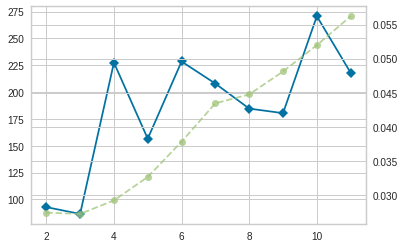

In [127]:
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(X)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

## Realização da  clusterização

In [128]:
qtde_cluster = 5

In [129]:
clusterer = KMeansClusterer(qtde_cluster, euclidean_distance, repeats=100)
clusters = clusterer.cluster(X, True)

In [130]:
df["cluster"] = clusters

## Quais são esses grupos?

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f80b15bcb38>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=12)

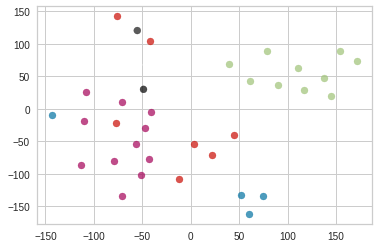

In [132]:
fig, ax = plt.subplots() 
tsne = TSNEVisualizer(random_state=12,decompose_by=7,perplexity=9)
tsne.fit(X, clusters)
#tsne.show()

In [133]:
for c in sorted(df["cluster"].unique()):
    print("Cluster ", c)
    display(HTML(df[df["cluster"] == c].to_html()))

Cluster  0


,review,produto,tamanho_review,substantivos,qtde_subs,cluster
0,"Não posso comparar com as outras geração pois esse é meu primeiro Kindle, mas como uma pessoa que gosta muito de ler e lia muito pelo celular, o Kindle tem uma enorme diferença, meu maior medo era que os olhos doessem, o que não aconteceu. Ele é maravilhoso. Só não recebi os 90 dias de kindle unlimited!",kindle,57,"[pessoa, geração, medo, diferença]",4,0
3,"Maravilhoso, anatômico e a luz realmente faz diferença na leitura. Não pesa as vistas. Perfeito",kindle,15,"[luz, vistas, diferença, perfeito, leitura]",5,0
4,"Amei esse kindle! Já tinha o outro, mais básico, mas a iluminação faz toda a diferença por causa da variação de luz dos ambientes externos.",kindle,25,"[variação, luz, causa, outro, diferença, iluminação]",6,0
12,"Aparelho veio com defeito, frustrante. Muita demora para resolver. Penso em devolver se não trocarem",echodot,15,"[defeito, aparelho]",2,0


Cluster  1


,review,produto,tamanho_review,substantivos,qtde_subs,cluster
21,"Recomendo esse livro para todos aqueles que querem ""virar a chave"" e começar a agir. Não é aqueles livros de autoajuda chatos que ficam dando fórmulas mágicas. É um livro para auto reflexão, especialmente pelos exemplos apresentados. Apresenta fundamentos científicos que explicam com bastante propriedade acerca do assunto.",livro,48,"[autoajuda, assunto, reflexão, mágicas, propriedade, livro, chatos, fundamentos, exemplos, chave]",10,1
22,Li em torno de 5 livros sobre a procrastinação e este foi o mais completo dentro desta proposta. Recomendo !,livro,20,"[proposta, procrastinação, li, torno]",4,1
23,"Adorei o livro, simples e direto. Foi indicação da minha Pisicologa e me ajudou muito, pois sou procrastinadora. Indico para todas as pessoas que têm dificuldades de planejar e executar.",livro,30,"[indico, indicação, direto, planejar, livro, dificuldades, pessoas]",7,1
24,"Livro excelente, não só escreve os sintomas e ações dos procrastinadores com oferece várias técnicas e procedimentos para superar este problema.",livro,21,"[procrastinadores, procedimentos, técnicas, ações, livro, problema]",6,1
25,"Recomendo a leitura para aqueles que têm o hábito de deixar para depois aquilo que deve ser feito. Irão se sentir muito melhores e sem o sentimento de culpa usual nos procrastinadores, se conseguirem reduzir/eliminar este hábito.",livro,37,"[procrastinadores, hábito, sentimento, culpa, leitura]",5,1
26,"O que mais me chamou a atenção no livro foi a explicação dos fenômenos da procrastinação baseados na ciência. Com explicações fáceis de entender, a autora parte da realidade em busca de soluções que atendam aos problemas em questão. Muito bom!",livro,41,"[explicação, atenção, soluções, realidade, questão, livro, procrastinação, fenômenos, ciência, autora, busca, explicações]",12,1
27,É um bom livro. Baseado em vários estudos científicos. Contém informações que nos faz entender o comportamento do cérebro quando tarefas são procrastinadas.,livro,23,"[tarefas, comportamento, estudos, livro, cérebro, informações]",6,1
28,"O livro sintetiza boa parte das ideias que sugere, trazendo boas fontes e referências. Mas há deslizes de revisão muito graves. O discurso dos últimos parágrafos, num mote “deixe de ser perdedor”, contrasta com os valores anti-palestra motivacional. E, salvo engano, não há maiores informações sobre a autoria - o que nos leva a pensar em um pseudônimo. Isso também enfraquece o trabalho.",livro,63,"[autoria, discurso, livro, “, engano, pseudônimo, trabalho, fontes, parte, deslizes, informações, revisão]",12,1
29,"O livro eh uma confusão de informações, mal estruturado, desorganizado. Da algumas linhas gerais sobre o assunto, mas precisaria melhorar muito para ganhar mais algumas estrelas.",livro,26,"[assunto, linhas, livro, confusão, estrelas, informações]",6,1
30,"Sério, os cachorros ficam meio enlouquecidos querendo mais, adoraram.",petisco_cachorro,9,[sério],1,1


Cluster  2


,review,produto,tamanho_review,substantivos,qtde_subs,cluster
2,"Que bom que colocaram iluminação nesse novo Kindle de 10ª geração pois prefiro o design dele ao paperwhite! Agora ficou perfeito, ótimo custo benefício, é o suficiente pra quem gosta de ler a qualquer hora do dia ou da noite e em qualquer lugar!",kindle,44,"[hora, noite, suficiente, iluminação, geração, paperwhite, lugar, design, dia]",9,2
7,"A bateria do meu Kindle não dura nem 3 dias. Não sei o que está acontecendo, já que o prometido era semanas. E digo isso levando em consideração que eu não utilizo nem 2 horas por dia",kindle,37,"[bateria, horas, consideração, prometido, dia]",5,2
8,"Eu possuía o kindle 7ª geração e vendi a fim de pegar p 10º (em função da iluminação embutida). Porém, estou amargamente arrependida. A bateria do meu anterior durava até 1 mês e meio, o 10ª geração com uma leitura de duas horas por dia (wifi desligado e iluminação no 12) dura em torno de 5 dias. Pedi troca do produto, comprei outro e pasmem! Veio da mesma forma. Eu mexo 5 minutos e a bateria já desce 5%! Aparentemente é a qualidade do aparelho que é inferior. Uma pena, sempre defendi os produtos da Amazon mas esse kindle novo deixou muuuuito a desejar. O diferencial do kindle é justamente a bateria e a desse é péssima. Mega insatisfeita.",kindle,119,"[bateria, função, qualidade, mês, anterior, aparelho, diferencial, horas, muuuuito, pena, iluminação, geração, produto, 10º, leitura, da, forma, dia, fim, torno]",20,2
16,"Muito boa. Ela tem design e dimensões bem discretas, serve para colocar em qualquer cômodo da cada sem medo de estragar a decoração ou algo do tipo (muito pelo contrário, ela combina com tudo!). A qualidade de som, comparado ao porte dela, é muito boa. Só calibrei um pouco os graves, para não ficar tão agudo e lá estava o som com uma qualidade bem legal. Volume suficiente para curtir um som sem incomodar vizinhos e afins, desde que seja ambiente interno (é claramente o foco dessa caixa, dado o porte). Os microfones tem um ótimo alcance e a Alexa funciona muito bem. Recomendo!",echodot,104,"[medo, qualidade, foco, som, contrário, volume, tipo, vizinhos, alcance, caixa, design, porte, cômodo, dimensões, decoração]",15,2
20,"Muito bom. Só podia funcionar juntamente com o Fire Stick e melhorar a função de escolha de playlist no Spotify (não reconhece e não coloca as músicas no aleatório), mas no geral é ok.",echodot,34,"[escolha, músicas, função]",3,2
32,"Minhas cachorras amaram, entregou super rápido, só que vieram muitos quebrados.",petisco_cachorro,11,"[quebrados, cachorras]",2,2
33,"Pratico e durável, minha cadela ama! Perfeito para levar como petisco durante uma caminhada ou passeio!",petisco_cachorro,16,"[pratico, cadela, petisco, caminhada, perfeito, passeio]",6,2


Cluster  3


,review,produto,tamanho_review,substantivos,qtde_subs,cluster
1,"Aparelho excelente, porém o site está com falta de capas para o aparelho, acredito ser um probleminha que incomoda para os mais perfeccionistas, um site tão grande deve se atentar a esses detalhes também não ganhei os 90 dias prometidos de kindle ulimited",kindle,43,"[site, probleminha, falta, aparelho, capas]",5,3
6,"Comprei o Kindle 10a geração acreditando que ele ia vir com os 4 GB, como a própria Amazon especifica na propaganda do produto e acreditando no que vem escrito na caixa do aparelho. E podem ter certeza de que não vêm. Me sinto extremamente enganada pela Amazon, o aparelho é lindo, comprei a cor branca por achar mais clássica e não me enganei quanto à isso, o design dele é espetacularmente lindo e bem delicado, mas quanto aos 4 GB que MENTIRA isso, paguei caro em um produto para não vir o que foi prometido. Que feio isso Amazon!!!",kindle,99,"[design, paguei, certeza, geração, sinto, aparelho, propaganda, cor, produto]",9,3
9,"Eu particularmente odiei, detestei o produto, eu ja tinha um iPad Pro e um Mini iPad, e resolvi comprar o Kindle, que erro que eu cometi!!! O processador dele é extremamente lento, existe um delay para os comandos em touch, uma porcaria! Arrependido!!!",kindle,43,"[porcaria, odiei, delay, produto, erro, processador, ipad]",7,3
10,"Desde a época que comprei meu primeiro Kindle, há aproximadamente 4 anos eu fiquei impressionado com a qualidade dos produtos Amazon e o Echo Dot faz jus ao nome. A qualidade da caixa sonora é impecável, não cheguei a usar no máximo com certo receio de perturbar os vizinhos (moro em apartamento), a Alexa responde de forma rápida aos comandos, apesar de ainda cometer alguns erros. Com a prática tem-se a perfeição. O usuário também precisa aprender a como se comunicar com a Alexa e sempre reportar os possíveis erros de comunicação pro aperfeiçoamento do sistema. Creio que a Alexa veio pra ficar e com esse dispositivo de alta qualidade como o Echo Dot, é possível utilizar a assistente ao máximo. Recomendo.",kindle,122,"[produtos, jus, prática, época, qualidade, receio, erros, perfeição, máximo, moro, comunicação, apartamento, assistente, sistema, dispositivo, usuário, forma, nome]",18,3
11,"Poderia dar uma nota maior, mas não funciona para tudo o que promete. O app Alexa não importa todos os contatos do telefone e assim não consigo usar para ligações. Se você não desembolsar para comprar caríssimos devices de lâmpada e tomada, o Echo acaba não servindo pra nada. Só serve para dizer tempo, hora e tocar música.",echodot,58,"[devices, app, nota, hora, música, ligações, tempo, telefone]",8,3
13,"O echo dot é super prático, fácil de configurar, é perfeito para quem quer uma smart home.",echodot,17,[echo],1,3
14,"Além de todas as funcionalidades que eu já esperava, como controlar a luz, criar alarmes e lembretes, tocar música no Spotify, entre outras, tive a surpresa de descobrir que ela lê meus ebooks do Kindle em voz alta e com uma entonação incrível (sem parecer artificial). As skills são um show a parte - minhas preferidas são a do Cinemark, Turma da Mônica e sons relaxantes (ampla variedade). Não testei ainda as skills do Uber e iFood.",echodot,77,"[luz, surpresa, voz, funcionalidades, música, alarmes, skills, turma, variedade, entonação, parte, show, parecer]",13,3
15,"Acho que a propaganda desse produto está sendo feita de forma errada hora nenhuma ele dá a impressão de que você precisa manter ele ligado em uma tomada para funcionar, vejam as fotos a forma de divulgação da impressão de ser algo com bateria que vc carrega pra cima e pra baixo, é bem chato isso. Apesar de não estar escrito sobre bateria no anúncio você tem essa impressão. O aparelho é bom, funciona tudo que promete mas fiquei bem chateado ao perceber que não existe o recurso de bateria e acho que deveria ficar bem explicita essa informação, decepção é o que define o que sinto.",echodot,107,"[bateria, tomada, cima, hora, escrito, anúncio, 

Cluster  4


,review,produto,tamanho_review,substantivos,qtde_subs,cluster
5,"É um produto que vale cada centavo! Estimula demais a leitura, é prático e super leve pra levar pra qualquer lugar.",kindle,21,"[estimula, lugar, leitura, centavo, produto]",5,4
31,"Meu cachorro adorou, estou usando como recompensa pra aprender a usar um tapete higiênico e tem dado certo por enquanto! Recomendo bastante tanto para raças pequenas como grandes",petisco_cachorro,28,"[tapete, cachorro, enquanto, recompensa, raças]",5,4
34,"Excelente biscoito, meu cachorro adorou. E pelo preço que paguei, saiu bem em conta. Recomendo",petisco_cachorro,15,"[cachorro, preço, recomendo, biscoito, conta]",5,4


### Cluster 0  -> avaliações apenas de petiscos de cachorro (100)
### Cluster 1 -> avaliações kindle (5/11) e echodot (3/10)
### Cluster 2 -> avaliações kindle (5/11), echodot(1/10), livro (1/9)
### Cluster 3 -> avaliações livro(8/9), avaliações kindle (1/11),
### Cluster 4 -> avaliações echodot (6/10)


In [134]:
df[df["cluster"] == 4]

,review,produto,tamanho_review,substantivos,qtde_subs,cluster
5,É um produto que vale cada centavo! Estimula d...,kindle,21,"[estimula, lugar, leitura, centavo, produto]",5,4
31,"Meu cachorro adorou, estou usando como recompe...",petisco_cachorro,28,"[tapete, cachorro, enquanto, recompensa, raças]",5,4
34,"Excelente biscoito, meu cachorro adorou. E pel...",petisco_cachorro,15,"[cachorro, preço, recomendo, biscoito, conta]",5,4


# Vamos gerar nuvens de palavras para entendermos um pouco mais os grupos

In [135]:
todaspalavras_cluster = {}
substantivos_clusters = {}
for cluster in sorted(df["cluster"].unique()):
    todaspalavras_cluster[cluster] = []
    substantivos_clusters[cluster] = []
    for nomes in df[df["cluster"] == cluster]["substantivos"].values:
        substantivos_clusters[cluster].extend(nomes)
    todaspalavras_cluster[cluster] = ' '.join(df[df["cluster"] == cluster]["review"].values)

## Quais são os substantivos de cada grupo?

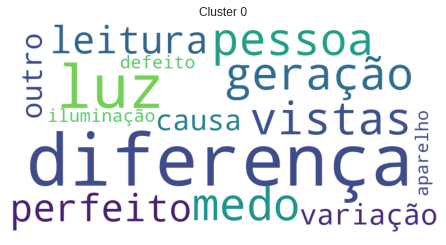

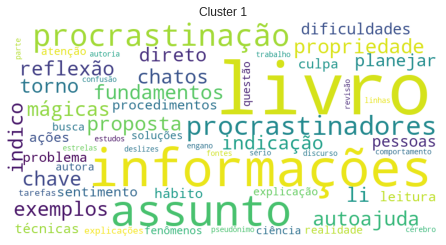

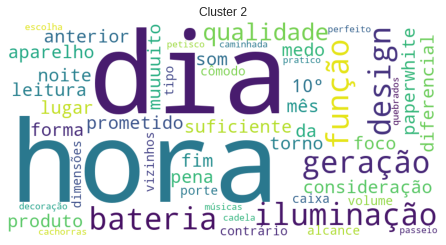

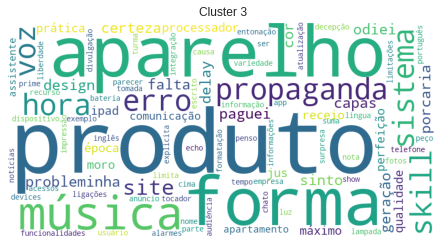

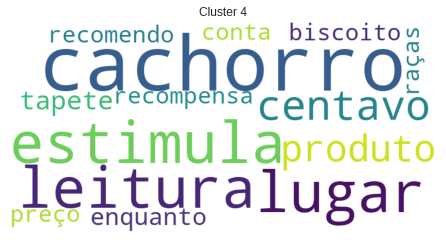

In [136]:
for k in substantivos_clusters.keys():
    wordcloud = substantivos_clusters[k]
    wordcloud_str = ' '.join(wordcloud)
    wordcloud = WordCloud(width=800, height=400, background_color ='white',
                      min_font_size = 7).generate(wordcloud_str)
    plt.figure(figsize=(8, 3), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title("Cluster "+str(k))
    plt.show()
    

## Conclusões


- O grupo 0 é muito bem caracterizado por palavras relacionadas a cachorro.
- Apesar do grupo 1 e 2 terem 5 reviews de kindle é possível observar que a abordagem entre elas é diferente devido a nuvem de palavras. No grupo 1 as avaliações focam nas diferenças entre as gerações, já o grupo 2 possui avaliações do produto como um meio de leitura.
- O grupo 3 é predominantemente composto de livros, e consequentemente apareceu a palavra livro e os diversos assuntos que são tratados nos livros, por exemplo: procrastinação, fundamentos, etc.
- No grupo 4 é possível perceber funcionaliades do echodot: música, ligações, contatos, etc

<b> Por que a palavra medo apareceu no grupo 1?</b>
Vamos analisar as frases?

<i> Não posso comparar com as outras geração pois esse é meu primeiro Kindle, mas como uma pessoa que gosta muito de ler e lia muito pelo celular, o Kindle tem uma enorme diferença, meu maior <b>medo</b> era que os olhos doessem, o que não aconteceu. Ele é maravilhoso. Só não recebi os 90 dias de kindle unlimited! (kindle)</i>


<i> 'Muito boa. Ela tem design e dimensões bem discretas, serve para colocar em qualquer cômodo da cada sem <b>medo</b> de estragar a decoração ou algo do tipo (muito pelo contrário, ela combina com tudo!). A qualidade de som, comparado ao porte dela, é muito boa. Só calibrei um pouco os graves, para não ficar tão agudo e lá estava o som com uma qualidade bem legal. Volume suficiente para curtir um som sem incomodar vizinhos e afins, desde que seja ambiente interno (é claramente o foco dessa caixa, dado o porte). Os microfones tem um ótimo alcance e a Alexa funciona muito bem. Recomendo!' (echodot) </i>


É posível perceber que os usuários que avaliaram esses produtos possuem determinada preocupações: medo de prejudicar a vista e medo de atrapalhar a decoração.

In [ ]:
#df[df["cluster"] == 3]["substantivos"].apply(lambda x : "informações" in x)

In [ ]:
#df.loc[29, "review"]

## Quais são as palavras das reviews em cada um dos grupos?

In [142]:
portugues_stops = stopwords.words('portuguese')

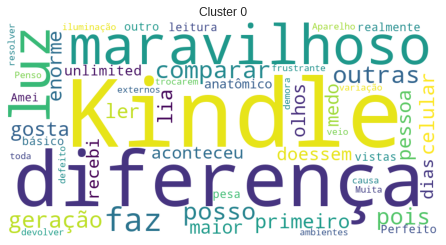

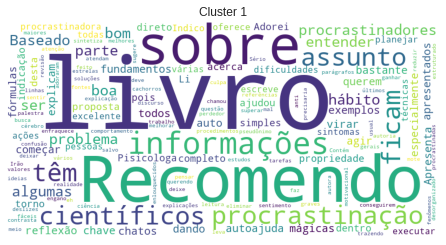

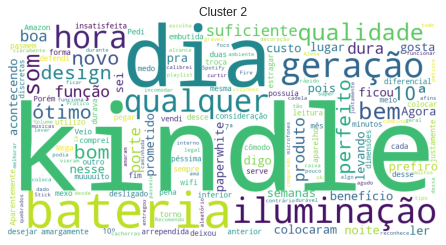

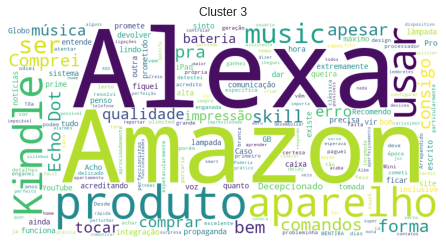

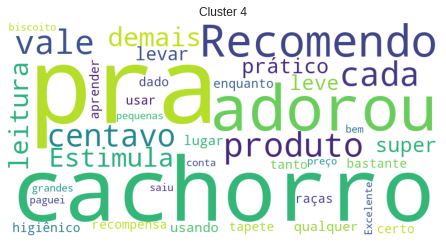

In [143]:
for k in todaspalavras_cluster.keys():
    wordcloud_str = todaspalavras_cluster[k]
    wordcloud = WordCloud(width=800, height=400, background_color ='white', stopwords=portugues_stops,
                      min_font_size = 7).generate(wordcloud_str)
    plt.figure(figsize=(8, 3), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title("Cluster "+str(k))
    plt.show()

## Conclusões


- Note que se olhamos para todas as palavras das reviews não conseguimos diferenciar muito bem os grupos 1 e 2.
- Há uma grande variabilidade de palavras e não conseguimos discrimar muito bem os grupos.

# Hipótese levantada:

Encontrar características do meu cliente através dos feedbacks

# Oportunidades Futuras

- Clusterização de clientes para gerar ações específicas